Este agarra el CSV de todas las especies, y carga los CSVs recortados para procesar y entrenar

### Modify these bounds and values for Data Selection

In [32]:
# Hyperparameters for Selection

MIN_LAT = -57.0 # decrease for more samples & species
MAX_LAT = -15.0 # increase for more samples & species

MIN_LON = -77.0 # decrease for more samples & species
MAX_LON = -48.0 # increase for more samples & species

SAMPLES_CUTOFF = 18 # decrease for more species
SEGMENTS_CUTOFF = 72 # decrease for more species
MIN_RATING_CUTOFF = 3.5 # decrease for more samples
MIN_AUTHORS_CUTOFF = 9 # decrease for more species

### The rest of the code below should remain unchanged.

In [33]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import librosa
import numpy as np
from collections import defaultdict
from tabulate import tabulate

In [34]:
# # Work is done, csv ya procesado
# # Load original CSV
# df = pd.read_csv('../database/train_metadata.csv')

# # Drop rows without coordinates
# df = df.dropna(subset=['latitude', 'longitude', 'filename', 'scientific_name', 'primary_label'])

# # Keep only specified columns
# cols = ['primary_label', 'latitude', 'longitude', 'scientific_name', 'common_name', 'filename', 'rating', 'author']
# df = df[cols]

# # Overwrite original file
# df.to_csv('../data/birdclef-2021/train_metadata.csv', index=False)
# df.to_csv('../database/train_metadata.csv', index=False)

# # Preview
# df.head(n=10)

In [35]:
from sklearn.preprocessing import LabelEncoder

latin_america_bounds = {
    "lat": (MIN_LAT, MAX_LAT),
    "lon": (MIN_LON, MAX_LON)
}

df = pd.read_csv(os.path.join('..', 'database', 'train_metadata.csv'))
print(f"DataFrame shape: {df.shape}")
df = df.dropna(subset=['latitude', 'longitude'])
df = df[df['filename'].notna() & (df['filename'] != '')]
df = df[~(df['scientific_name'].isna() & df['common_name'].isna())]
print(f"DataFrame shape after 'cuts': {df.shape}")
df.head(n=10)

DataFrame shape: (62874, 8)
DataFrame shape after 'cuts': (62874, 8)


,primary_label,latitude,longitude,scientific_name,common_name,filename,rating,author
0,acafly,35.3860,-84.1250,Empidonax virescens,Acadian Flycatcher,XC109605.ogg,2.5,Mike Nelson
1,acafly,9.1334,-79.6501,Empidonax virescens,Acadian Flycatcher,XC11209.ogg,3.0,Allen T. Chartier
2,acafly,5.7813,-75.7452,Empidonax virescens,Acadian Flycatcher,XC127032.ogg,3.0,Sergio Chaparro-Herrera
3,acafly,4.6717,-75.6283,Empidonax virescens,Acadian Flycatcher,XC129974.ogg,3.5,Oscar Humberto Marin-Gomez
4,acafly,4.6717,-75.6283,Empidonax virescens,Acadian Flycatcher,XC129981.ogg,3.5,Oscar Humberto Marin-Gomez
5,acafly,4.6717,-75.6283,Empidonax virescens,Acadian Flycatcher,XC130056.ogg,4.0,Oscar Humberto Marin-Gomez
6,acafly,4.6717,-75.6283,Empidonax virescens,Acadian Flycatcher,XC130133.ogg,4.0,Oscar Humberto Marin-Gomez
7,acafly,4.6717,-75.6283,Empidonax virescens,Acadian Flycatcher,XC130140.ogg,4.0,Oscar Humberto Marin-Gomez
8,acafly,4.6717,-75.6283,Empidonax virescens,Acadian Flycatcher,XC130750.ogg,4.0,Oscar Humberto Marin-Gomez
9,acafly,4.6717,-75.6283,Empidonax virescens,Acadian Flycatcher,XC131193.ogg,3.0,Oscar Humberto Marin-Gomez


In [36]:
def in_region(lat, lon):
    return (latin_america_bounds['lat'][0] <= lat <= latin_america_bounds['lat'][1] and
            latin_america_bounds['lon'][0] <= lon <= latin_america_bounds['lon'][1])

df['region'] = df.apply(lambda row: 'Latin America' if in_region(row['latitude'], row['longitude']) else None, axis=1)
region_df = df[df['region'].notna()][['primary_label', 'latitude', 'longitude', 'scientific_name', 'common_name', 'region', 'filename', 'author']]

# Add sample count per species
species_counts = region_df['scientific_name'].value_counts().to_dict()
region_df['amount_of_samples'] = region_df['scientific_name'].map(species_counts)

total_samples = len(region_df)
total_species = region_df['scientific_name'].nunique()

print(f"Total samples: {total_samples}")
print(f"Total distinct species: {total_species}")

Total samples: 2240
Total distinct species: 111


In [37]:
# Drop rows where 'author' is NaN
region_df = region_df.dropna(subset=['author'])

# Create and apply label encoding to 'author' column
author_encoder = LabelEncoder()
region_df['author'] = author_encoder.fit_transform(region_df['author'])

print(f"Updated DataFrame shape: {region_df.shape}")
print(f"Number of unique authors: {region_df['author'].nunique()}")
region_df.head()

Updated DataFrame shape: (2240, 9)
Number of unique authors: 182


,primary_label,latitude,longitude,scientific_name,common_name,region,filename,author,amount_of_samples
465,aldfly,-19.5501,-62.5623,Empidonax alnorum,Alder Flycatcher,Latin America,XC2628.ogg,164,1
1004,amekes,-33.2140,-70.9456,Falco sparverius,American Kestrel,Latin America,XC127418.ogg,63,10
1010,amekes,-16.9334,-66.8667,Falco sparverius,American Kestrel,Latin America,XC16111.ogg,133,10
1024,amekes,-32.1440,-53.7280,Falco sparverius,American Kestrel,Latin America,XC267262.ogg,145,10
1041,amekes,-21.0944,-52.4465,Falco sparverius,American Kestrel,Latin America,XC418891.ogg,64,10


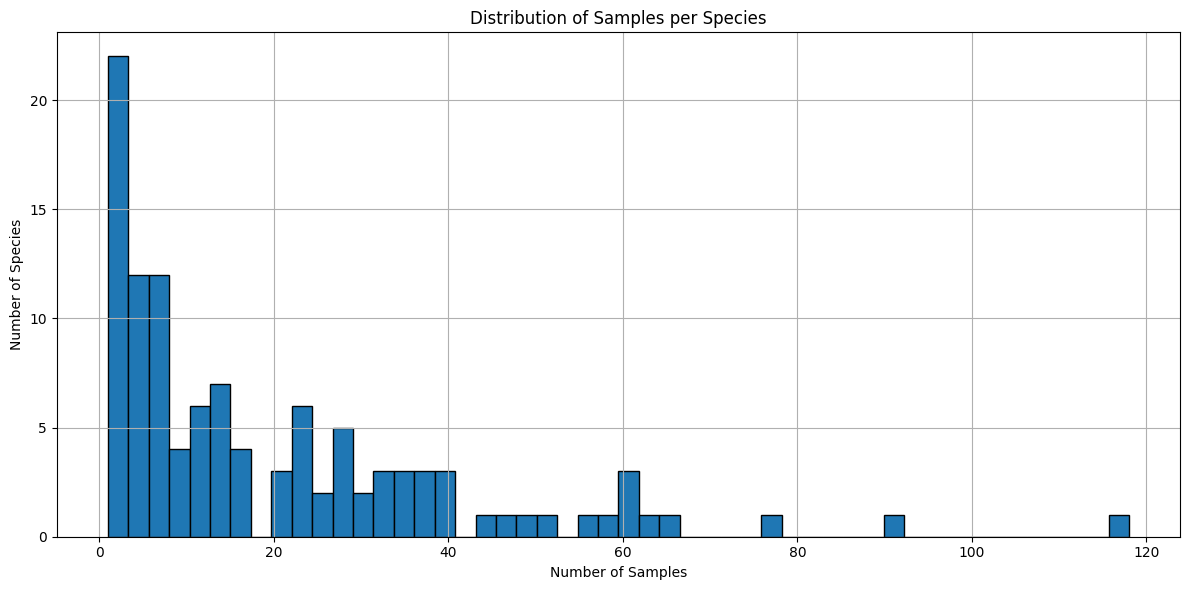

In [38]:
species_counts = region_df['scientific_name'].value_counts()

plt.figure(figsize=(12, 6))
species_counts.hist(bins=50, edgecolor='black')
plt.xlabel('Number of Samples')
plt.ylabel('Number of Species')
plt.title('Distribution of Samples per Species')
plt.grid(True)
plt.tight_layout()
plt.show()

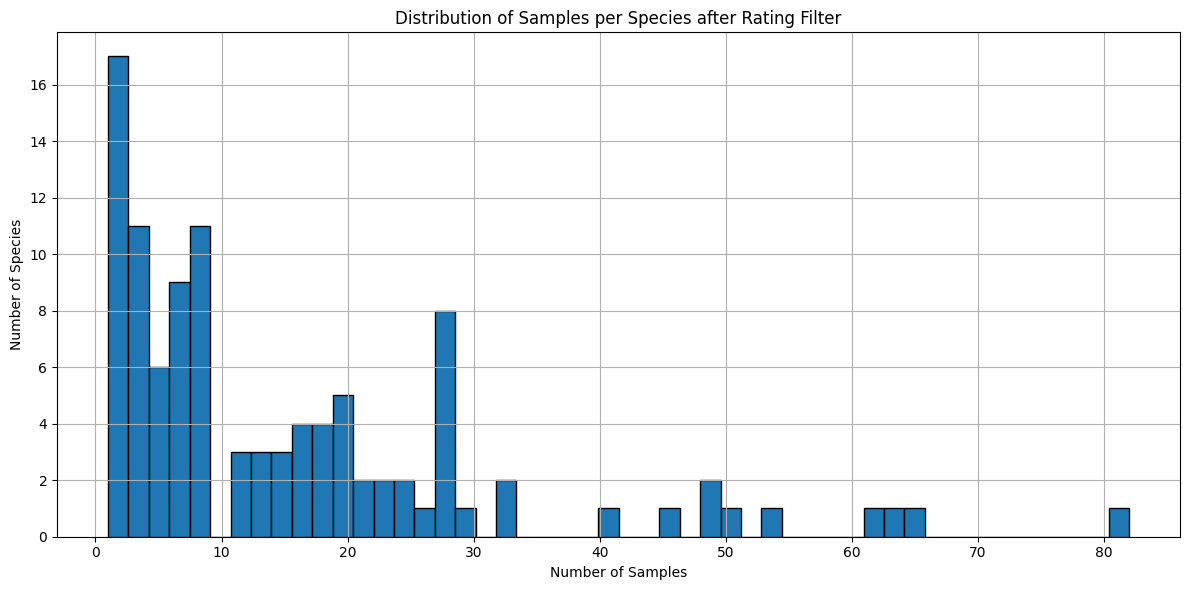

Total samples: 1638
Total distinct species: 104


In [39]:
rated_df = region_df[df.loc[region_df.index, 'rating'] >= MIN_RATING_CUTOFF]
rated_species_counts = rated_df['scientific_name'].value_counts()

plt.figure(figsize=(12, 6))
rated_species_counts.hist(bins=50, edgecolor='black')
plt.xlabel('Number of Samples')
plt.ylabel('Number of Species')
plt.title('Distribution of Samples per Species after Rating Filter')
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Total samples: {len(rated_df)}")
print(f"Total distinct species: {rated_df['scientific_name'].nunique()}")

In [40]:
# Assuming rated_df is your DataFrame and contains 'primary_label' and 'filename' columns
segment_sec = 5.0
sr = 32000
samples_per_segment = int(sr * segment_sec)
frame_len = 2048
hoplen = 512
thresh_factor = 0.75

usable_segments = []

for _, row in rated_df.iterrows():
    primary_label = row['primary_label']
    filename = row['filename']
    audio_path = os.path.join('../data/birdclef-2021/train_short_audio', primary_label, filename)

    try:
        y, srate = librosa.load(audio_path, sr=sr, mono=True)
    except Exception as e:
        print(f"Error loading audio file {audio_path}: {e}")
        usable_segments.append(0)
        continue

    rms = librosa.feature.rms(y=y, frame_length=frame_len, hop_length=hoplen)[0]
    threshold = thresh_factor * np.mean(rms)
    count = 0

    for start in range(0, len(y) - samples_per_segment + 1, samples_per_segment):
        segment = y[start:start + samples_per_segment]
        seg_rms = np.mean(librosa.feature.rms(y=segment)[0])
        if seg_rms < threshold:
            continue
        count += 1

    usable_segments.append(count)

segs_df = rated_df.copy()
segs_df['usable_segments'] = usable_segments

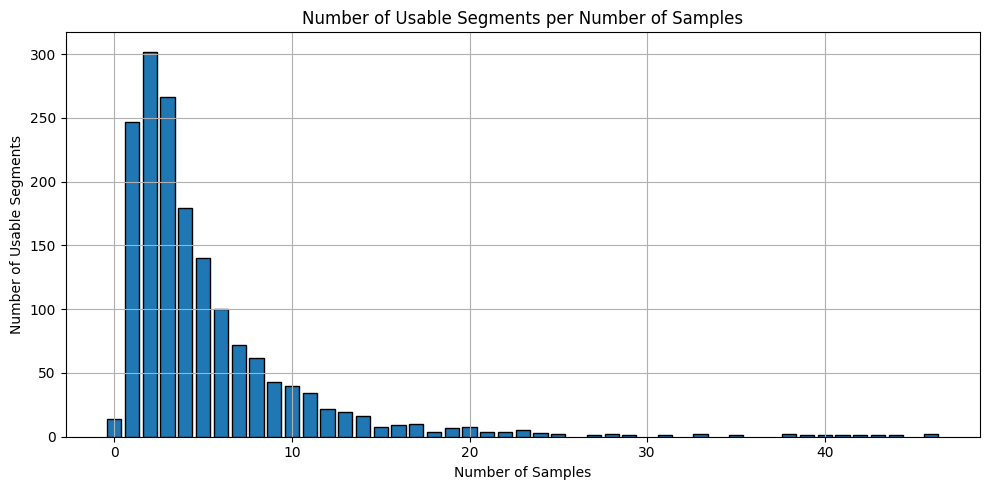

In [41]:
seg_counts = segs_df['usable_segments'].value_counts().sort_index()
plt.figure(figsize=(10, 5))
plt.bar(seg_counts.index, seg_counts.values, edgecolor='black', align='center')
plt.xlabel('Number of Samples')
plt.ylabel('Number of Usable Segments')
plt.title('Number of Usable Segments per Number of Samples')
plt.grid(True)
plt.tight_layout()
plt.show()

In [42]:
species_sample_counts = segs_df['scientific_name'].value_counts()
species_segment_counts = segs_df.groupby('scientific_name')['usable_segments'].sum()

species_to_keep = [
    species for species in species_sample_counts.index
    if species_sample_counts[species] >= SAMPLES_CUTOFF and species_segment_counts[species] >= SEGMENTS_CUTOFF
]

minsmps_df = segs_df[segs_df['scientific_name'].isin(species_to_keep)].copy()
summary_table = minsmps_df.groupby('scientific_name').agg(
    samples_count=('scientific_name', 'count'),
    unique_segments_count=('usable_segments', 'sum')
).reset_index()

# Sort by unique_segments_count ascending
summary_table = summary_table.sort_values('unique_segments_count', ascending=True)

# Pretty print the table
print(tabulate(summary_table, headers='keys', tablefmt='github', showindex=False))

| scientific_name           |   samples_count |   unique_segments_count |
|---------------------------|-----------------|-------------------------|
| Volatinia jacarina        |              19 |                      73 |
| Coereba flaveola          |              19 |                      80 |
| Nyctibius griseus         |              23 |                      84 |
| Legatus leucophaius       |              19 |                      87 |
| Crotophaga ani            |              18 |                      88 |
| Patagioenas plumbea       |              20 |                      89 |
| Synallaxis albescens      |              18 |                      93 |
| Chlorospingus flavopectus |              22 |                     105 |
| Psarocolius decumanus     |              23 |                     109 |
| Pitangus sulphuratus      |              27 |                     111 |
| Synallaxis azarae         |              30 |                     111 |
| Camptostoma obsoletum     |         

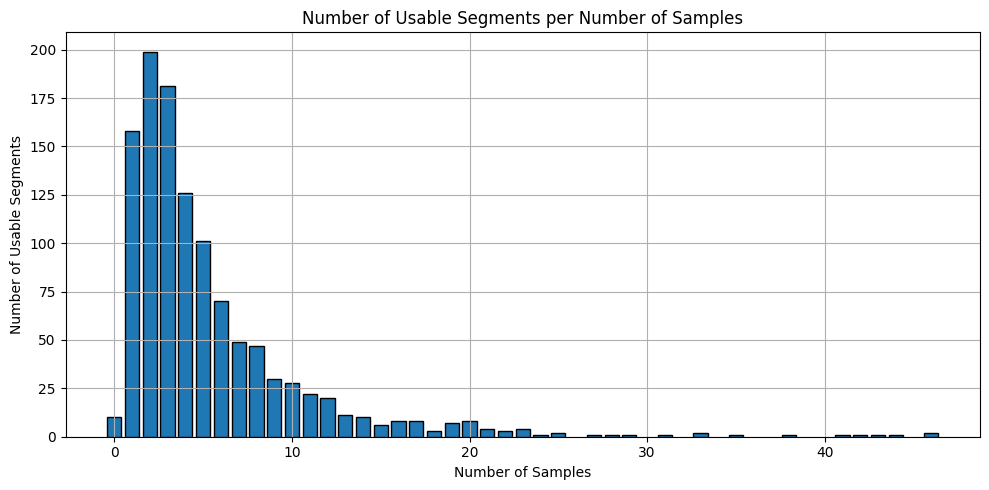

In [43]:
seg_counts = minsmps_df['usable_segments'].value_counts().sort_index()
plt.figure(figsize=(10, 5))
plt.bar(seg_counts.index, seg_counts.values, edgecolor='black', align='center')
plt.xlabel('Number of Samples')
plt.ylabel('Number of Usable Segments')
plt.title('Number of Usable Segments per Number of Samples')
plt.grid(True)
plt.tight_layout()
plt.show()

In [44]:
# Final Amount of Samples and Species
print(f"Almost Final Amount of samples: {len(minsmps_df)}")
print(f"Almost Final Amount of species: {minsmps_df['scientific_name'].nunique()}")

Almost Final Amount of samples: 1130
Almost Final Amount of species: 33


In [45]:

# Get author counts per species
author_counts_per_species = minsmps_df.groupby('scientific_name')['author'].nunique()

# Find species with less than 2 unique authors
species_with_few_author = author_counts_per_species[author_counts_per_species < MIN_AUTHORS_CUTOFF]

print(f"Species with less than {MIN_AUTHORS_CUTOFF} unique authors ({len(species_with_few_author)} species):")
print("=" * 60)
for species, author_count in species_with_few_author.items():
    print(f"{species}: {author_count} author(s)")

# Filter out species with less than 2 unique authors
species_to_keep_multiauthor = author_counts_per_species[author_counts_per_species >= MIN_AUTHORS_CUTOFF].index
authors_df = minsmps_df[minsmps_df['scientific_name'].isin(species_to_keep_multiauthor)]

print(f"\nAfter filtering species with less than {MIN_AUTHORS_CUTOFF} unique authors:")
print(f"Remaining samples: {len(authors_df)}")
print(f"Remaining species: {authors_df['scientific_name'].nunique()}")

Species with less than 9 unique authors (0 species):

After filtering species with less than 9 unique authors:
Remaining samples: 1130
Remaining species: 33


In [46]:
# Load the Class IDs for training
final_df = authors_df[['primary_label', 'scientific_name', 'common_name', 'filename', 'author', 'usable_segments']].copy()

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
final_df['class_id'] = le.fit_transform(final_df['scientific_name'])

# Save species to CSV
final_df.to_csv(os.path.join('..', 'database', 'meta', 'final_species.csv'), index=False)

# Build mapping with class_id, scientific_name, common_name
mapping_df = final_df[['class_id', 'scientific_name', 'common_name']].drop_duplicates().sort_values('class_id')
mapping_df.to_csv(os.path.join('..', 'database', 'meta', 'class_mapping.csv'), index=False)

In [47]:
print(f"Final DataFrame shape: {final_df.shape}")
print(f"Final number of samples: {len(final_df)}")
print(f"Final number of usable segments: {final_df['usable_segments'].sum()}")
print(f"Final number of species: {final_df['scientific_name'].nunique()}")

Final DataFrame shape: (1130, 7)
Final number of samples: 1130
Final number of usable segments: 6095
Final number of species: 33
